In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Define the parameters of the system

w       = 1
deff    = 1
n2w     = 1
c       = 1
Ew      = 1

dk_max  = 2e0
z_max   = 1.2e1
z_int   = 1.1e1

alpha   = w * deff * Ew**2 / (n2w * c)
alpha   = 1e-1

# Define the parameters of the neural network

n_input     = 2
n_output    = 1
n_hidden    = 50

In [4]:
# For testing purposes, we define the solution of the EDP

def sol(dz, index=None):
    E = -1J * alpha * z_int * np.sin(dz * z_int / 2) / (dz * z_int / 2) * np.exp(1J * (dz * z_int / 2))

    if index == 'real':
        return np.real(E)
    elif index == 'imag':
        return np.imag(E)
    else:
        return np.abs(E)

In [5]:
class Second_harmonic(nn.Module):
    # Defines the Neural Network that we're going to use for train our solution
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.input1        = nn.Linear(n_input, n_hidden)          # Define the input later for our NN
        self.hidden1       = nn.Linear(n_hidden, n_hidden)         # Defines hidden layers for our NN 
        self.output1       = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

        self.input2        = nn.Linear(n_input, n_hidden)          # Define the input later for our NN
        self.hidden2       = nn.Linear(n_hidden, n_hidden)         # Defines hidden layers for our NN 
        self.output2       = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

    def forward(self, x, y):
        n_layer = 3
        inputs  = torch.cat([x, y], axis = 1)

        # Channel 1

        input1  = self.input1(inputs)
        input1  = torch.tanh(input1)
        
        for i in range(n_layer):
            input1 = self.hidden1(input1)
            input1 = torch.tanh(input1)

        out1    = self.output1(input1)

        # Channel 2

        input2  = self.input2(inputs)
        input2  = torch.tanh(input2)

        for i in range(n_layer):
            input2 = self.hidden2(input2)
            input2 = torch.tanh(input2)
        
        out2    = self.output2(input2)

        # Outputs

        outputs = torch.cat([out1, out2], axis = 1)
        
        return outputs

In [6]:
# Create the neural network with the parameters defined before

PINN    = Second_harmonic(n_input, n_output, n_hidden)
PINN    = PINN.to(device=device)

In [7]:
# Define the elements required for train the neural network

N_bound     = 1000
N_domain    = 150
N_train     = 20001

loss_values = []
loss_test   = []

# Create the grid for domain

dk_domain   = torch.linspace(-dk_max, dk_max, N_domain, device=device)
# dk_domain   = torch.cat((dk_domain, torch.linspace(0, dk_max, int(N_domain/5), device=device)))
z_domain    = torch.linspace(0, z_max, N_domain, device=device)

dk_domain, z_domain = torch.meshgrid(dk_domain, z_domain, indexing='ij')

dk_domain   = dk_domain.reshape(-1, 1).requires_grad_(True)
z_domain    = z_domain.reshape(-1, 1).requires_grad_(True)

# Now, we create the grid for the boundary condition

dk_bound    = torch.linspace(-dk_max, dk_max, N_bound, device=device).reshape(-1, 1)
z_bound     = torch.zeros_like(dk_bound, device=device)

# We create the test domain

dk_test     = torch.linspace(-dk_max, dk_max, 10*N_domain, device=device)
z_test      = 11*torch.ones_like(dk_test)

dk_test     = dk_test.reshape(-1, 1)
z_test      = z_test.reshape(-1, 1)

# Create the solution NN-type to compare with our model

dk_true     = dk_test.to('cpu').detach().numpy()
Er_true     = sol(dk_true, index='real').reshape(1, -1)
Ei_true     = sol(dk_true, index='imag').reshape(1, -1)

In [ ]:
# Train our model

# Define the weights for the loss function and the optimizer

w1  = 1e1
w2  = 1e2

optimizer   = torch.optim.Adam(PINN.parameters(), lr=5e-4)

for train_iter in range(N_train):
    optimizer.zero_grad()

    # Compute all the derivatives functions for implement the EDP
    E       = PINN(dk_domain, z_domain)

    dEdz_r  = torch.autograd.grad(E[:, 0], z_domain, torch.ones_like(E[:, 0]), create_graph=True)[0]
    dEdz_i  = torch.autograd.grad(E[:, 1], z_domain, torch.ones_like(E[:, 1]), create_graph=True)[0]

    eq_r    = dEdz_r - alpha * torch.sin(dk_domain * z_domain)
    eq_i    = dEdz_i + alpha * torch.cos(dk_domain * z_domain)
    ls_edp  = torch.sum((eq_r)**2) + torch.sum((eq_i)**2)

    # Introduce the constraint related with the boundary condition
    E_bound = PINN(dk_bound, z_bound)
    
    ls_bc   = torch.sum((E_bound)**2)

    # Create the loss function to train the model

    loss    = w1 * ls_edp + w2 * ls_bc

    # Compute the test loss

    E_test  = PINN(dk_test, z_test)

    Er_test = E_test[:, 0]
    Ei_test = E_test[:, 1]
    Er_test = Er_test.to('cpu')
    Ei_test = Ei_test.to('cpu')
    Er_test = Er_test.detach().numpy()
    Ei_test = Ei_test.detach().numpy()

    ls1_test    = np.sum( ( Er_test - Er_true )**2 )
    ls2_test    = np.sum( ( Ei_test - Ei_true )**2 )

    # Start the train updating the weights of the neural networks

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    loss_test.append(ls1_test + ls2_test)

    if train_iter % 1000 == 0:
        print('iteration '+str(train_iter)+' complete test loss =', [loss.item(), ls1_test, ls2_test])

In [ ]:
w1  = 1e1
w2  = 1e2

optimizer   = torch.optim.Adam(PINN.parameters(), lr=1e-3)

for train_iter in range(N_train):
    optimizer.zero_grad()

    # Compute all the derivatives functions for implement the EDP
    E       = PINN(dk_domain, z_domain)

    dEdz_r  = torch.autograd.grad(E[:, 0], z_domain, torch.ones_like(E[:, 0]), create_graph=True)[0]
    dEdz_i  = torch.autograd.grad(E[:, 1], z_domain, torch.ones_like(E[:, 1]), create_graph=True)[0]

    eq_r    = dEdz_r - alpha * torch.sin(dk_domain * z_domain)
    eq_i    = dEdz_i + alpha * torch.cos(dk_domain * z_domain)
    ls_edp  = torch.sum((eq_r)**2) + torch.sum((eq_i)**2)

    # Introduce the constraint related with the boundary condition
    E_bound = PINN(dk_bound, z_bound)
    
    ls_bc   = torch.sum((E_bound)**2)

    # Create the loss function to train the model

    loss    = w1 * ls_edp + w2 * ls_bc

    # Compute the test loss

    E_test  = PINN(dk_test, z_test)

    Er_test = E_test[:, 0]
    Ei_test = E_test[:, 1]
    Er_test = Er_test.to('cpu')
    Ei_test = Ei_test.to('cpu')
    Er_test = Er_test.detach().numpy()
    Ei_test = Ei_test.detach().numpy()

    ls1_test    = np.sum( ( Er_test - Er_true )**2 )
    ls2_test    = np.sum( ( Ei_test - Ei_true )**2 )

    # Start the train updating the weights of the neural networks

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    loss_test.append(ls1_test + ls2_test)

    if train_iter % 1000 == 0:
        print('iteration '+str(train_iter)+' complete test loss =', [loss.item(), ls1_test, ls2_test])

In [ ]:
plt.plot(range(len(loss_values)), loss_values, color='red', label='Train loss')
plt.plot(range(len(loss_test)), loss_test, color='blue', label='Test loss')
plt.grid()
plt.xlabel('Number of traines')
plt.ylabel('Loss function value')
plt.legend(loc=0)
# plt.ylim([0,10])

plt.show()

In [9]:
# Plot the results

dk  = torch.linspace(-dk_max, dk_max, 10*N_domain, device=device).reshape(-1, 1)
z   = z_int * torch.ones_like(dk)

E   = PINN(dk, z)
E_r = E[:, 0]
E_i = E[:, 1]

E_r = E_r.to('cpu')
E_i = E_i.to('cpu')

E_r = E_r.detach().numpy()
E_i = E_i.detach().numpy()

E   = np.sqrt(E_r**2 + E_i**2)

dk  = dk.to('cpu')
dk  = dk.detach().numpy()

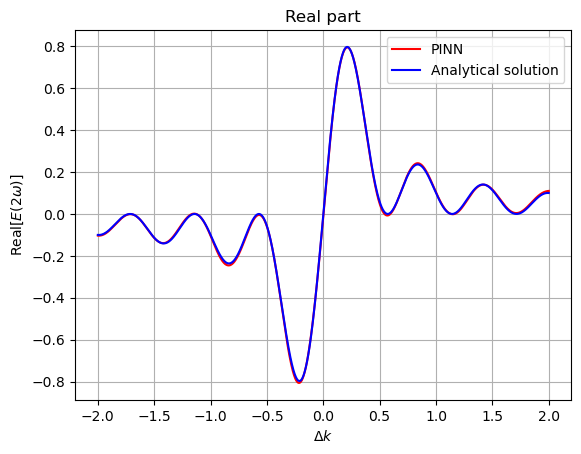

In [10]:
plt.clf()
plt.plot(dk, E_r, color='red', label='PINN')
plt.plot(dk, sol(dk, index='real'), color='blue', label='Analytical solution')
plt.grid()
plt.title('Real part')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$\mathrm{Real}[E(2 \omega)]$')
plt.legend(loc=0)

plt.show()

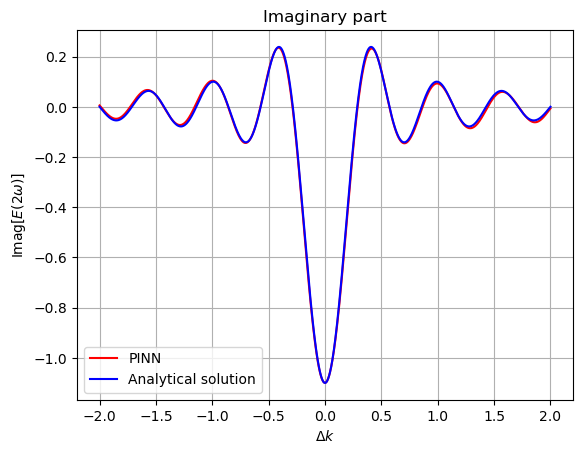

In [11]:
plt.clf()
plt.plot(dk, E_i, color='red', label='PINN')
plt.plot(dk, sol(dk, index='imag'), color='blue', label='Analytical solution')
plt.grid()
plt.title('Imaginary part')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$\mathrm{Imag}[E(2 \omega)]$')
plt.legend(loc=0)

plt.show()

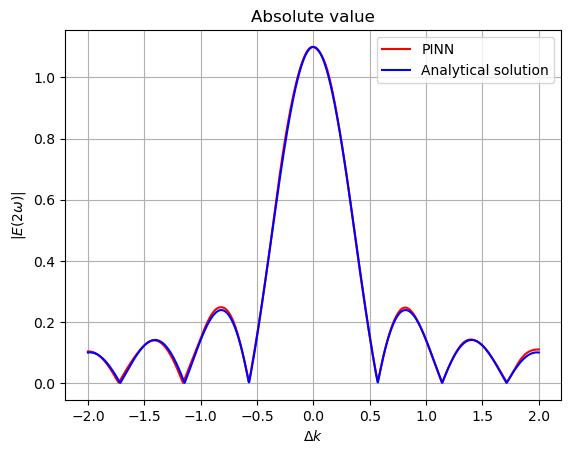

In [12]:
plt.clf()
plt.plot(dk, E, color='red', label='PINN')
plt.plot(dk, sol(dk), color='blue', label='Analytical solution')
plt.grid()
plt.title('Absolute value')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$|E(2 \omega)|$')
plt.legend(loc=0)

plt.show()

In [13]:
# Save the model (run this cell to save the model)

# torch.save(PINN.state_dict(), 'checkpoint.pth')

In [14]:
# Load the model (run this cell if you previously saved a trained model)

# trained_model = torch.load('checkpoint.pth', map_location=torch.device('cpu'))

# PINN.load_state_dict(trained_model)

In [15]:
# Compute the acumulative error for the estimation

Error = np.abs(E - sol(dk).reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the absolute field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the absolute field is 1.788% precise


In [16]:
Error = np.abs(E_r - sol(dk, index='real').reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the real part field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the real part field is 1.629% precise


In [17]:
Error = np.abs(E_i - sol(dk, index='imag').reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the imaginary part field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the imaginary part field is 2.305% precise
